In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
from scipy.integrate import dblquad
from scipy.optimize import approx_fprime
from mpl_toolkits.mplot3d import Axes3D

# import numdifftools as nd
# np.tensordot
# np.cross
# np.dot

# Just the cap

In [3]:
def vt(X: np.ndarray) -> np.ndarray:
    """Returns the tangent and azimutal unit vectors at point X on the unit sphere.
    Args:
        X (np.ndarray): A 3D point on the unit sphere.
        Returns:
        [-y/(x^2+y^2)^0.5, x/(x^2+y^2)^0.5, 0]"""
    s = np.sqrt(X[0]**2 + X[1]**2)
    return np.array([-X[1]/s, X[0]/s, 0])

def vr(X: np.ndarray) -> np.ndarray:
    """Returns the radial unit vector at point X on the unit sphere.
    Args:
        X (np.ndarray): A 3D point on the unit sphere.
        Returns:
        [X[0], X[1], X[2]]/(np.sqrt(X[0]**2 + X[1]**2 + X[2]**2))"""
    s = np.sqrt(X[0]**2 + X[1]**2+ X[2]**2)
    return np.array([X[0], X[1], X[2]])/s

def th(X: np.ndarray):
    """Returns the polar angle theta at point X on the unit sphere theta."""
    return np.arccos(X[2]/np.sqrt(X[0]**2 + X[1]**2 + X[2]**2))

def ncone(X: np.ndarray, w) -> np.ndarray:
    """Returns the director n on the boundary of the cone at point X on the unit sphere.
    Args:
        X (np.ndarray): A 3D point on the unit sphere.
        thetacone (float): The half-angle of the cone in radians.
        w (int): The winding number of the director along the boundary on the cone.
        Returns:
        n = cos(w*phi)*vt + sin(w*phi)*vr
        where phi = arctan2(y,x)
        
        if x=0 then we separate fo different cases"""
    if X[0] == 0 and X[1] == 0:
        return np.zeros(3)
    elif X[0] == 0 and X[1] > 0:   
        return np.cos(w * np.pi / 2) * vt(X) + np.sin(w * np.pi / 2) * vr(X)
    elif X[0] == 0 and X[1] < 0:
        return np.cos(w * np.pi / 2) * vt(X) - np.sin(w * np.pi / 2) * vr(X)        
    else:
        return np.cos(w * np.arctan2(X[1], X[0])) * vt(X) + np.sin(w * np.arctan2(X[1], X[0])) * vr(X)
    


def nhat(X, thetacone: float, w) -> np.ndarray:
    """Returns the director n at point X on the unit sphere.
    Args:
        X (np.ndarray): A 3D point on the unit sphere.
        thetacone (float): The half-angle of the cone in radians.
        w (int): The winding number of the director along the boundary on the cone.
        Returns:
        n = """
    n = th(X) * ncone(X, w) + (thetacone - th(X)) * np.array([0, 0, 1])
    return n / np.linalg.norm(n)


In [4]:
def epsilon3d():
    eps = np.zeros((3,3,3))
    eps[0,1,2]=eps[1,2,0]=eps[2,0,1]=1
    eps[0,2,1]=eps[1,0,2]=eps[2,1,0]=-1
    return eps

In [5]:
def integrand(point, angle, winding) -> np.ndarray:
    """epsilon_ijk epsilon_pqr n_q,i n_r,k n_p at point on the unit sphere.
    Args:
        point (np.ndarray): A 3D point on the unit sphere.
        angle (float): The half-angle of the cone in radians.
        winding (int): The winding number of the director along the boundary on the cone.
        Returns:
        A scalar representing the integrand at the given point."""
    grad_nx = approx_fprime(point, lambda p: nhat(p, angle, winding)[0], epsilon=1e-8)  # x-component - 3d vector
    grad_ny = approx_fprime(point, lambda p: nhat(p, angle, winding)[1], epsilon=1e-8)  # y-component - 3d vector
    grad_nz = approx_fprime(point, lambda p: nhat(p, angle, winding)[2], epsilon=1e-8)  # z-component - 3d vector

    n = nhat(point, angle, winding)  # 3d vector
    dn = np.stack((grad_nx, grad_ny, grad_nz), axis=0)  # 3x3 matrix
    r = np.array([point[0], point[1], point[2]])
    # print(dn)
    return np.round(0.5 * np.einsum('ijk,pqr,qj,rk,p,i', epsilon3d(), epsilon3d(), dn, dn, n, r) * th(point), decimals=8) # scalar: epsilon_ijk epsilon_pqr n_q,i n_r,k n_p, 0.5 because the einsum doubles it



In [6]:
# Implementation: Convert your integrand to spherical coordinates

def spherical_to_cartesian(theta, phi, r=1.0):
    """Convert spherical coordinates to Cartesian"""
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)  
    z = r * np.cos(theta)
    return np.array([x, y, z])

def integrand_spherical(theta, phi, angle=np.pi/4, winding=1):
    """
    Your integrand function adapted for spherical coordinates
    
    This function:
    1. Converts (θ,φ) to Cartesian point on unit sphere
    2. Calls your existing integrand function
    3. Returns scalar value ready for integration
    """
    # Convert to Cartesian coordinates
    point_cartesian = spherical_to_cartesian(theta, phi)
    
    # Call your existing integrand function
    result = integrand(point_cartesian, angle, winding)
    
    return result

# integrand_spherical(theta=np.pi/3, phi=0, angle=np.pi/4, winding=3)



In [7]:
# Using scipy.integrate.dblquad 

def charge(angle=np.pi/2, winding=0):
    """
    Compute surface integral using scipy.integrate.dblquad
    
    ∫∫_sphere integrand(θ,φ) sin(θ) dθ dφ
    """
    
    def integrand_with_jacobian(theta, phi):
        """Include the sin(θ) Jacobian factor"""
        return integrand_spherical(theta, phi, angle, winding) * np.sin(theta)
    
    # Integrate over the cap: θ ∈ [0,angle], φ ∈ [0,2π]
    result, error = integrate.dblquad(
        integrand_with_jacobian,
        0, 2*np.pi,          # φ limits
        lambda phi: 10 ** -8,       # θ lower bound (constant)
        lambda phi: angle    # θ upper bound (constant)
    )
    
    return result / (4 * np.pi), error



In [8]:
result, error = charge()
result

0.48947995968208863

In [19]:
#visualization of the director field on the sphere
def plot_vector_field(angle=np.pi/4, winding=1, num_points=20):
    """Plot the director field on a cap of the sphere."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a grid of points on the sphere
    theta = np.linspace(0, angle, num_points)
    phi = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    # Convert spherical to Cartesian coordinates for plotting
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    # Compute the director field at each point
    u = np.zeros_like(x)
    v = np.zeros_like(y)
    w = np.zeros_like(z)
    
    for i in range(num_points):
        for j in range(num_points):
            point = np.array([x[i,j], y[i,j], z[i,j]])
            n = nhat(point, angle, winding)
            u[i,j], v[i,j], w[i,j] = n
    
    # Plot the sphere surface
    # ax.plot_surface(x, y, z, color='c', alpha=0.3, rstride=1, cstride=1)
    
    # Plot the vector field
    ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(rf'Director Field ($\theta cone$ = {angle/np.pi}$\pi$, winding={winding})')
    plt.show()

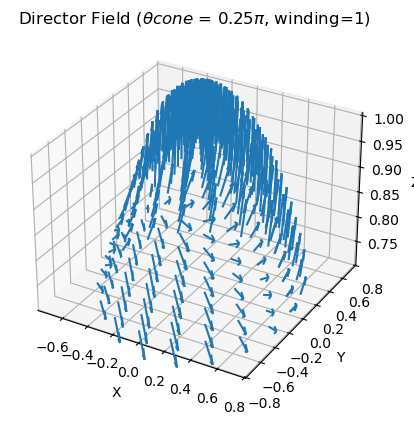

In [20]:
plot_vector_field(angle=np.pi/4, winding=1)

# Region with a hole

In [23]:
# RESTORED: Director field function for hole configuration
def nhat_for_hole(X, thetaup, thetadown, wup, wdown) -> np.ndarray:
    """Returns the director n at point X on the unit sphere for a hole.
    Args:
        X (np.ndarray): A 3D point on the unit sphere.
        thetaup (float): The upper half-angle of the cone in radians.
        thetadown (float): The lower half-angle of the cone in radians.
        wup (int): The winding number of the director along the boundary on the upper cone.
        wdown (int): The winding number of the director along the boundary on the lower cone.
        Returns:
        n = (th(X)- thetadown) * ncone(X, wup) + (thetaup - th(X)) * ncone(X, wdown)
        """
    n = (th(X)- thetadown) * ncone(X, wup) + (thetaup - th(X)) * ncone(X, wdown)
    return n / np.linalg.norm(n)



In [24]:
# RESTORED: Integrand function for hole configuration - PROBLEM WITH THE GRADIENTS???? HAS A NON ZERO ONLY IN Y DIRECTION
def integrand_for_hole(point, thetaup, thetadown, wup, wdown) -> np.ndarray:
    """epsilon_ijk epsilon_pqr n_q,i n_r,k n_p at point on the unit sphere for a hole.
    Args:
        point (np.ndarray): A 3D point on the unit sphere.
        thetaup (float): The upper half-angle of the cone in radians.
        thetadown (float): The lower half-angle of the cone in radians.
        wup (int): The winding number of the director along the boundary on the upper cone.
        wdown (int): The winding number of the director along the boundary on the lower cone.
        Returns:
        A scalar representing the integrand at the given point."""
    grad_nx = approx_fprime(point, lambda p: nhat_for_hole(p, thetaup, thetadown, wup, wdown)[0], epsilon=1e-8)  # x-component - 3d vector
    grad_ny = approx_fprime(point, lambda p: nhat_for_hole(p, thetaup, thetadown, wup, wdown)[1], epsilon=1e-8)  # y-component - 3d vector
    grad_nz = approx_fprime(point, lambda p: nhat_for_hole(p, thetaup, thetadown, wup, wdown)[2], epsilon=1e-8)  # z-component - 3d vector
    n = nhat_for_hole(point, thetaup, thetadown, wup, wdown)  # 3d vector
    dn = np.stack((grad_nx, grad_ny, grad_nz), axis=0)  # 3x3 matrix
    r = np.array([point[0], point[1], point[2]])
    res = 0.5 * np.einsum('ijk,pqr,qj,rk,p,i', epsilon3d(), epsilon3d(), dn, dn, n, r)
    # print(dn)
    return res # scalar: epsilon_ijk epsilon_pqr n_q,i n_r,k n_p, the 0.5 is because the einsum counts each term twice

integrand_for_hole(spherical_to_cartesian(theta=np.pi/3, phi=0), np.pi/4, np.pi/8, 3, 1)

0.0

In [25]:
np.stack((np.array([1,2,3]),np.array([4,5,6]),np.array([7,8,9])))

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [26]:
# RESTORED: Spherical coordinate conversion for hole integrand
def integrand_spherical_for_hole(theta, phi, thetaup=np.pi/4, thetadown=np.pi/2, wup=0, wdown=0):
    """
    Your integrand function adapted for spherical coordinates for a hole
    
    This function:
    1. Converts (θ,φ) to Cartesian point on unit sphere
    2. Calls your existing integrand function for a hole
    3. Returns scalar value ready for integration
    """
    # Convert to Cartesian coordinates
    point_cartesian = spherical_to_cartesian(theta, phi)
    
    # Call your existing integrand function for a hole
    result = integrand_for_hole(point_cartesian, thetaup, thetadown, wup, wdown)

    return result

integrand_spherical_for_hole(theta=np.pi/3, phi=0, thetaup=np.pi/4, thetadown=np.pi/8, wup=3, wdown=1)

0.0

In [27]:
# RESTORED: Charge calculation function for hole (FIXED VERSION)
def charge_for_hole(thetaup=np.pi/4, thetadown=np.pi/2, wup=0, wdown=0):
    """
    Compute surface integral using scipy.integrate.dblquad for a hole
    
    ∫∫_sphere integrand(θ,φ) sin(θ) dθ dφ
    """
    
    def integrand_with_jacobian(theta, phi):
        """Include the sin(θ) Jacobian factor"""
        res = integrand_spherical_for_hole(theta, phi, thetaup, thetadown, wup, wdown) * np.sin(theta)
        # print(f"theta: {theta}, phi: {phi}, integrand: {res}")
        return res
        # return integrand_spherical_for_hole(theta, phi, thetaup, thetadown, wup, wdown) * np.sin(theta) --- IGNORE ---
    
    """ Integrate over the hole region: θ ∈ [θup,θdown], φ ∈ [0,2π] """
    result, error = dblquad(
        integrand_with_jacobian,
        0, 2*np.pi,              # φ limits
        lambda phi: thetaup,     # θ lower bound (constant) - its the upper theta of the cone 
        lambda phi: thetadown    # θ upper bound (constant) - its the lower theta of the cone
    )
    
    return result / (4 * np.pi), np.round(error / (4 * np.pi), 6)

In [28]:
wup = 4
wdown = 2

charge_for_hole(thetaup=np.pi/5,thetadown=np.pi/2,wup=wup, wdown=wdown)[0]

-8.979161504809669e-10

In [29]:
# RESTORED: Vector field visualization for hole configuration
def plot_hole_vector_field(wup=1, wdown=3, thetaup=np.pi/4, thetadown=np.pi/2):
    """
    Plot the vector field nhat on the hole region
    """
    
    # Generate grid points on the sphere for the hole region
    theta = np.linspace(thetaup, thetadown, 20)
    phi = np.linspace(3*np.pi/2, 2 * np.pi, 40)
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    # Convert spherical to cartesian coordinates
    X = np.sin(theta_grid) * np.cos(phi_grid)
    Y = np.sin(theta_grid) * np.sin(phi_grid)
    Z = np.cos(theta_grid)

    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    W = np.zeros_like(Z)

    # Compute director field at each point
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pt = np.array([X[i, j], Y[i, j], Z[i, j]])
            n = nhat_for_hole(pt, thetaup, thetadown, wup, wdown)
            U[i, j], V[i, j], W[i, j] = n

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot director field
    ax.quiver(X, Y, Z, U, V, W, length=0.1, normalize=True, label='Director field')
    
    # Compute and plot perpendicular vector field
    U_perp = np.zeros_like(U)
    V_perp = np.zeros_like(V)
    W_perp = np.zeros_like(W)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            n_vec = np.array([U[i, j], V[i, j], W[i, j]])
            r_vec = np.array([X[i, j], Y[i, j], Z[i, j]])
            perp = np.cross(n_vec, r_vec)
            if np.linalg.norm(perp) > 0:
                perp = perp / np.linalg.norm(perp)
            U_perp[i, j], V_perp[i, j], W_perp[i, j] = perp

    # Shift perpendicular vectors to midpoint
    mid_X = X + 0.5 * U * 0.1
    mid_Y = Y + 0.5 * V * 0.1
    mid_Z = Z + 0.5 * W * 0.1

    ax.quiver(mid_X, mid_Y, mid_Z, U_perp, V_perp, W_perp, 
              length=0.1, normalize=True, color='orange', label='Perpendicular field')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(rf'Vector field on hole region ($w_{{up}}$={wup}, $w_{{down}}$={wdown})')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

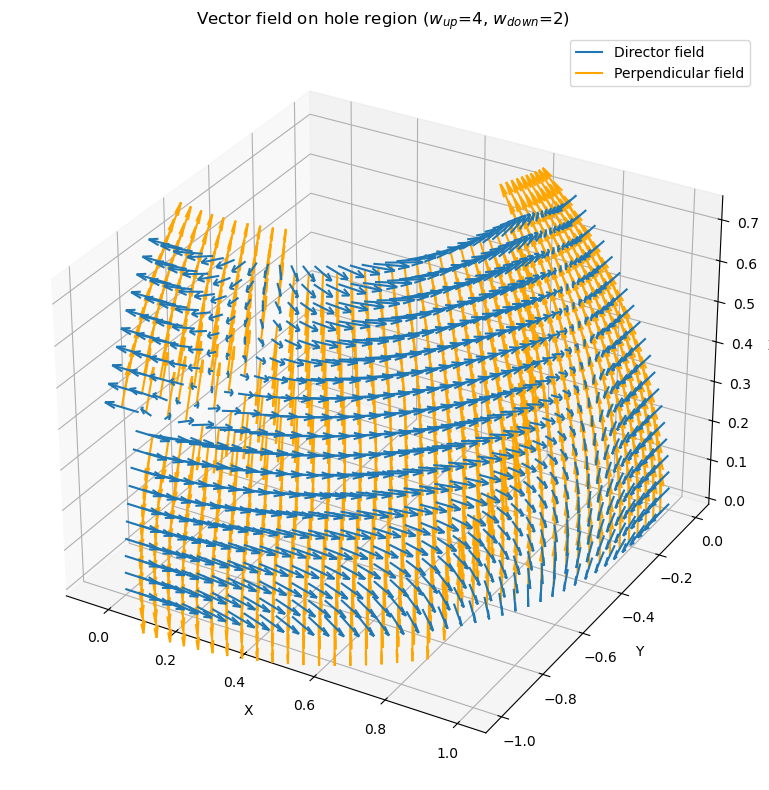

In [30]:
plot_hole_vector_field(wup, wdown, thetaup=np.pi/4, thetadown=np.pi/2)

In [31]:
def integrand_radial_field(point) -> np.ndarray:    
    
    grad_nx = approx_fprime(point, lambda p: vr(p)[0], epsilon=1e-8)  # x-component - 3d vector
    grad_ny = approx_fprime(point, lambda p: vr(p)[1], epsilon=1e-8)  # y-component - 3d vector
    grad_nz = approx_fprime(point, lambda p: vr(p)[2], epsilon=1e-8)  # z-component - 3d vector
    n = vr(point)  # 3d vector
    dn = np.stack((grad_nx, grad_ny, grad_nz), axis=0)  # 3x3 matrix
    r = np.array([point[0], point[1], point[2]])
    res = 0.5 * np.einsum('ijk,pqr,qj,rk,p,i', epsilon3d(), epsilon3d(), dn, dn, n, r)
    # print(dn)
    return res # scalar: epsilon_ijk epsilon_pqr n_q,i n_r,k n_p, the 0.5 is because the einsum counts each term twice

def integrand_spherical_radial_field(theta, phi):
    """
    Your integrand function adapted for spherical coordinates for a radial field
    
    This function:
    1. Converts (θ,φ) to Cartesian point on unit sphere
    2. Calls your existing integrand function for a radial field
    3. Returns scalar value ready for integration
    """
    # Convert to Cartesian coordinates
    point_cartesian = spherical_to_cartesian(theta, phi)
    
    # Call your existing integrand function for a radial field
    result = integrand_radial_field(point_cartesian)

    return result

def charge_radial_field(thetaup, thetadown):
    """
    Compute surface integral using scipy.integrate.dblquad for a radial field
    
    ∫∫_sphere integrand(θ,φ) sin(θ) dθ dφ
    """
    
    def integrand_with_jacobian(theta, phi):
        """Include the sin(θ) Jacobian factor"""
        res = integrand_spherical_radial_field(theta, phi) * np.sin(theta)
        # print(f"theta: {theta}, phi: {phi}, integrand: {res}")
        return res
    
    """ Integrate over the full sphere: θ ∈ [0,π], φ ∈ [0,2π] """
    result, error = dblquad(
        integrand_with_jacobian,
        0, 2*np.pi,              # φ limits
        lambda phi: thetaup,           # θ lower bound (constant)
        lambda phi: thetadown        # θ upper bound (constant)
    )
    
    return np.round(result / (4 * np.pi),6), np.round(error / (4 * np.pi), 6)

In [46]:
ch1 = charge(np.pi/5,3)[0]

In [47]:
ch2 = charge_radial_field(np.pi/5, np.pi/2)[0]

In [48]:
ch3 = charge(np.pi/2, 4)[0]

In [52]:
np.round(ch1,2)-np.round(ch2,2)+np.round(ch3,2)

-2.21

In [50]:
ch1-ch2+ch3

-2.218242226487207

In [53]:
ch4 = charge_for_hole(thetaup=np.pi/5,thetadown=np.pi/2,wup=3, wdown=4)[0]

In [54]:
ch1-  ch4+  ch3

-1.8137342275713912